In [87]:
import numpy as np
import pandas as pd
import math
from numpy.linalg import inv
import plotly.express as px

pd.options.plotting.backend = "plotly"

In [114]:
# Utils

def plot_state_vs_time(df):    
    fig = df.plot()
    fig.update_layout(height=700)
    fig.show()
    
def plot_path(df, x, y):
    fig = px.line(df, x='Position (X)', y='Position (Y)', height=1200)
    if x is not None:
        fig.add_scatter(x=df[x], y=df[y], mode='lines')
    fig.show()

In [89]:
# State Integrators
class RK4_Integrator:
    def __init__(self, x_0, t_0, t_n, dt, dx):
        self.x_0 = x_0
        self.t_0 = t_0
        self.t_n = t_n
        self.dt = dt
        self.dx = dx
        
        self.x = None
        self.t = None
    
    def step(self, u = None):
        if self.t is not None and (self.t + self.dt) > self.t_n:
            return None
        
        if self.x is None:
            self.x = self.x_0
            self.t = self.t_0
        else:
            x = self.x
            t = self.t
            dt = self.dt
            
            k1 = self.dx(x, t, u)
            k2 = self.dx(x + dt * k1 / 2, t + dt / 2, u)
            k3 = self.dx(x + dt * k2 / 2, t + dt / 2, u)
            k4 = self.dx(x + dt * k3, t + dt, u)
        
            x = x + dt * (k1 + 2*k2 + 2*k3 + k4) * (1/6)
            
            self.x = x
            self.t += self.dt
        
        return self.x, self.t

In [105]:
# Vessel dymaics

M = np.array([
    [25.8, 0, 0],
    [0, 33.8, 6.2],
    [0, 6.2, 2.76]
])

Bt = np.array([
    [1, 0],
    [0, 0],
    [0, 1]
])

Minv = inv(M)

def eta(u, v, sai):
    return np.array([u, v, sai]).T

def nu(x, y, r):
    return np.array([x, y, r]).T

# def x(x, y, r, u, v, sai):
#     return np.array([x, y, r, u, v, sai]).T

def C(V):
    u = V[0][0]
    v = V[1][0]
    r = V[2][0]
    c13 = -33.8*v -(6.2+6.2)*r/2
    c23 = 25.8*u
    return np.array([
        [0, 0, c13],
        [0, 0, c23],
        [-c13, -c23, 0]
    ])

# def D(V):
#     u = V[0]
#     v = V[1]
#     r = V[2]
#     return -np.array([
#         [-12 - 2.1 * abs(u), 0, 0],
#         [0, -17 - 4.5 * abs(v) , -0.2],
#         [0, -0.5, -0.5 - 0.1 * abs(r)]
#     ])

# To remove abs, we have to make sure force stays constant
def D(V):
    u = V[0][0]
    v = V[1][0]
    r = V[2][0]
    return -np.array([
        [-12 - 2.1 * u, 0, 0],
        [0, -17 - 4.5 * v , -0.2],
        [0, -0.5, -0.5 - 0.1 * -r]
    ])

def R(sai):
    return np.array([
        [np.cos(sai), -np.sin(sai), 0],
        [np.sin(sai), np.cos(sai), 0],
        [0, 0, 1]
    ])


def B():
    a = np.array([
        [0, 0],
        [0, 0],
        [0, 0]
    ])
    b = Minv@Bt
    c = np.concatenate((a, b), axis=0)
    return c

def fx(X):
    V = X[3:]
    sai = X[2][0]
    
    a = R(sai) @ V
    b = -Minv @ (C(V) + D(V)) @ V
    c = np.array([a, b]).reshape((-1, 1))
    return c

# X = [x, y, r, u, v, sai]
def dx(X, t = None, U = np.array([0, 0]).reshape((-1, 1))):
    return fx(X) + (B() @ U)

# testing
X_0 = np.array([1, 2, 3, 4, 5, 6]).reshape((-1, 1))
U = np.array([0, 0]).reshape((-1, 1))

dx(
    X_0, 
    t = 0, 
    U = U
)

array([[ -4.66557003],
       [ -4.38548245],
       [  6.        ],
       [ 44.79069767],
       [ -6.03602684],
       [-99.01327305]])

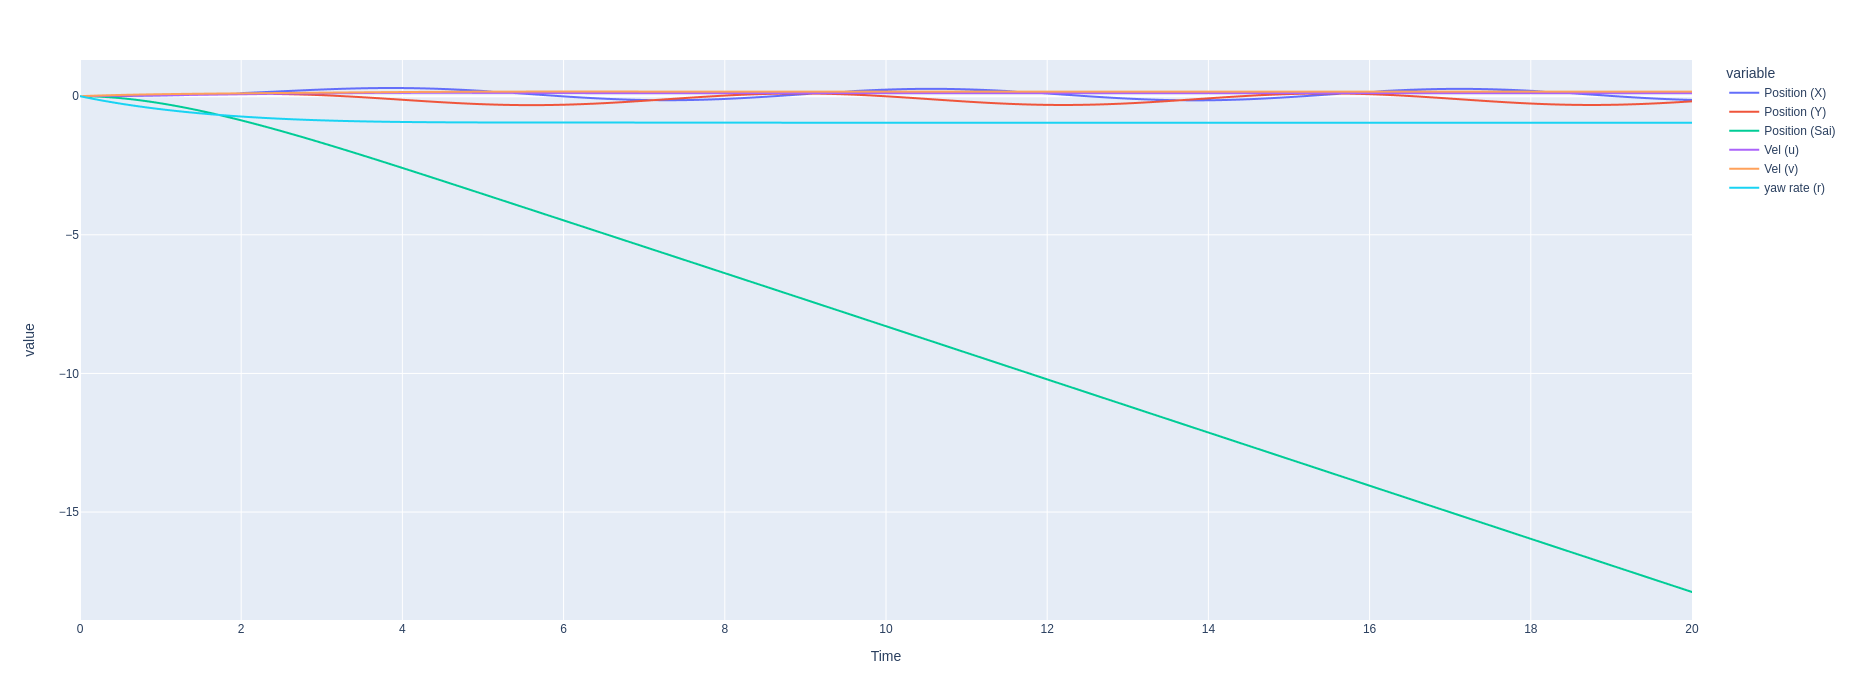

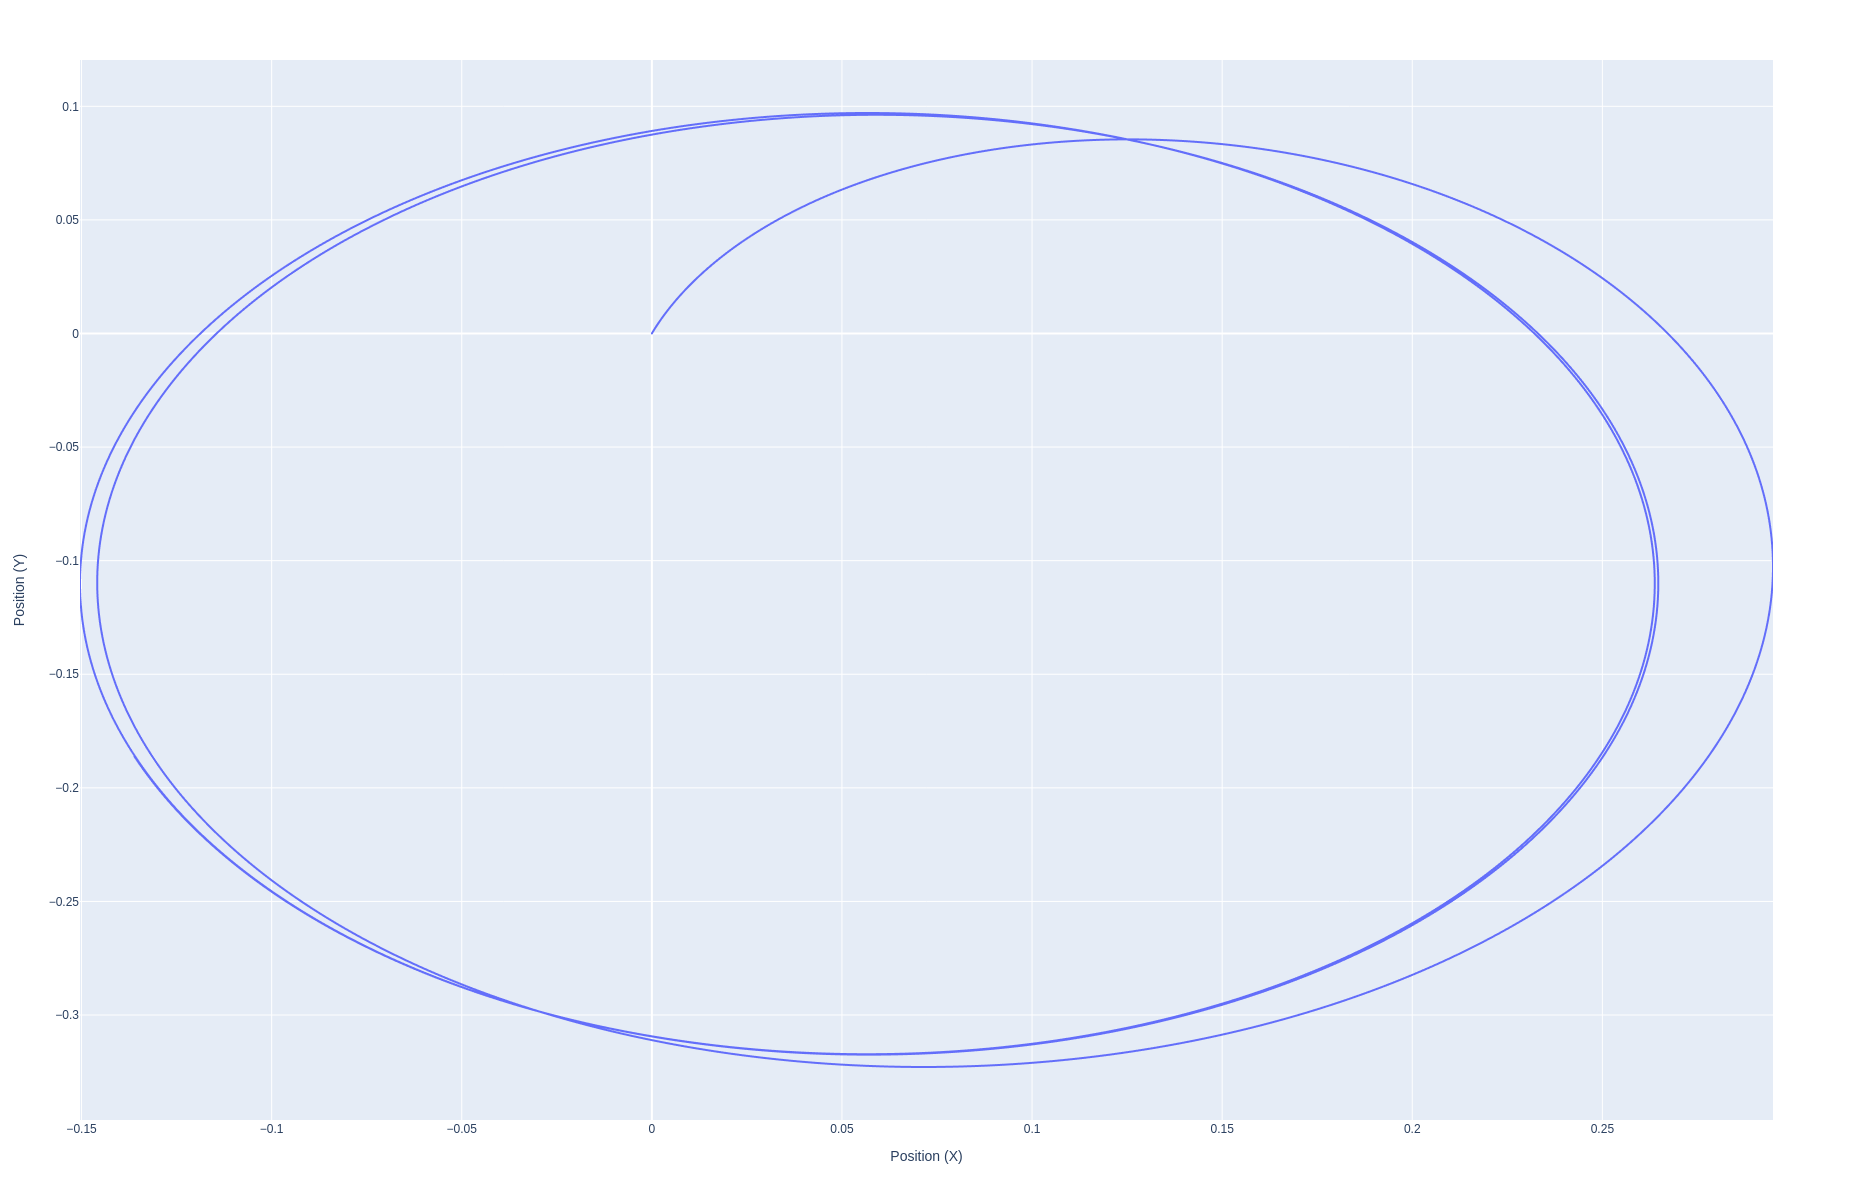

,Position (X),Position (Y),Position (Sai),Vel (u),Vel (v),yaw rate (r)
Time,,,,,,
0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.016,0.000005,0.000014,-0.000079,0.000618,0.001794,-0.009814
0.032,0.000020,0.000057,-0.000314,0.001231,0.003557,-0.019538
0.048,0.000044,0.000128,-0.000703,0.001840,0.005291,-0.029171
0.064,0.000079,0.000226,-0.001247,0.002444,0.006997,-0.038716
...,...,...,...,...,...,...
19.936,-0.131063,-0.197862,-17.821439,0.110582,0.164954,-0.958583
19.952,-0.132387,-0.194973,-17.836777,0.110582,0.164954,-0.958583
19.968,-0.133667,-0.192065,-17.852114,0.110582,0.164954,-0.958583


In [106]:
def run():
    X_0 = np.array([0, 0, 0, 0, 0, 0]).reshape((-1, 1))
    U = np.array([1, -1]).reshape((-1, 1))

    t_0 = 0
    T = 20.0
    dt = 0.016

    state_time = []
    state_integrator = RK4_Integrator(X_0, t_0, T, dt, dx)
    
    while True:
        result = state_integrator.step(U)
        
        if result is None:
            break
        else:
            x, t = result
            state_time.append({
                "Position (X)": x[0][0], 
                "Position (Y)": x[1][0], 
                "Position (Sai)": x[2][0], 
                "Vel (u)": x[3][0], 
                "Vel (v)": x[4][0], 
                "yaw rate (r)": x[5][0], 
                "Time": t
            })
        
    r_state_time_df = pd.DataFrame(state_time).set_index("Time")

    # state_time_df = pd.concat([r_state_time_df, e_state_time_df])
    plot_state_vs_time(r_state_time_df)
    plot_path(r_state_time_df)
    return r_state_time_df, state_time
    
state_time_df, state_time = run()
state_time_df

In [107]:
# For r -ve and u, v +ve

Jf = lambda x,y,psi,u,v,r: (np.array([[0, 0, -u*math.sin(psi) - v*math.cos(psi), math.cos(psi), -math.sin(psi), 0], [0, 0, u*math.cos(psi) - v*math.sin(psi), math.sin(psi), math.cos(psi), 0], [0, 0, 0, 0, 0, 1], [0, 0, 0, -0.162790697674419*u - 0.465116279069767, 1.31007751937984*r, 0.48062015503876*r + 1.31007751937984*v], [0, 0, 0, -0.597432905484247*r + 0.904317386231039*v, 0.904317386231039*u - 0.452887981330222*v - 0.798935239206535, -0.022607934655776*r - 0.597432905484247*u + 0.0464556592765461], [0, 0, 0, -0.904317386231039*r - 4.92998833138856*v, -4.92998833138856*u + 1.01735705950992*v + 1.61355017502917, 0.123249708284714*r - 0.904317386231039*u - 0.285516336056009]]))

# testing
Jf(1, 2, 3, 4, 5, 6)

array([[  0.        ,   0.        ,   4.38548245,  -0.9899925 ,
         -0.14112001,   0.        ],
       [  0.        ,   0.        ,  -4.66557003,   0.14112001,
         -0.9899925 ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   1.        ],
       [  0.        ,   0.        ,   0.        ,  -1.11627907,
          7.86046512,   9.43410853],
       [  0.        ,   0.        ,   0.        ,   0.9369895 ,
          0.5538944 ,  -2.47892357],
       [  0.        ,   0.        ,   0.        , -30.07584597,
        -13.01961785,  -3.16328763]])

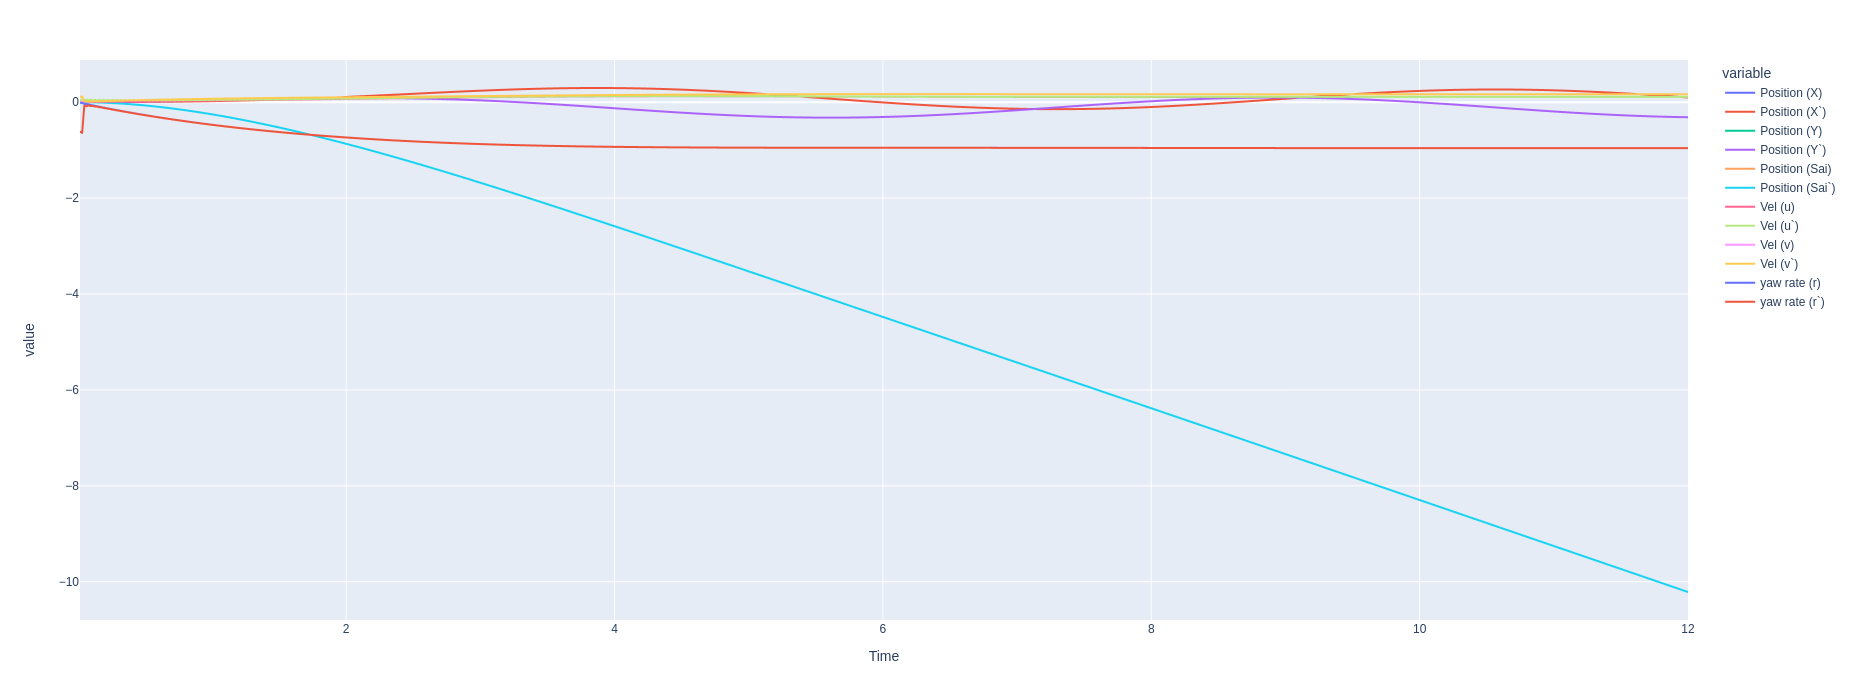

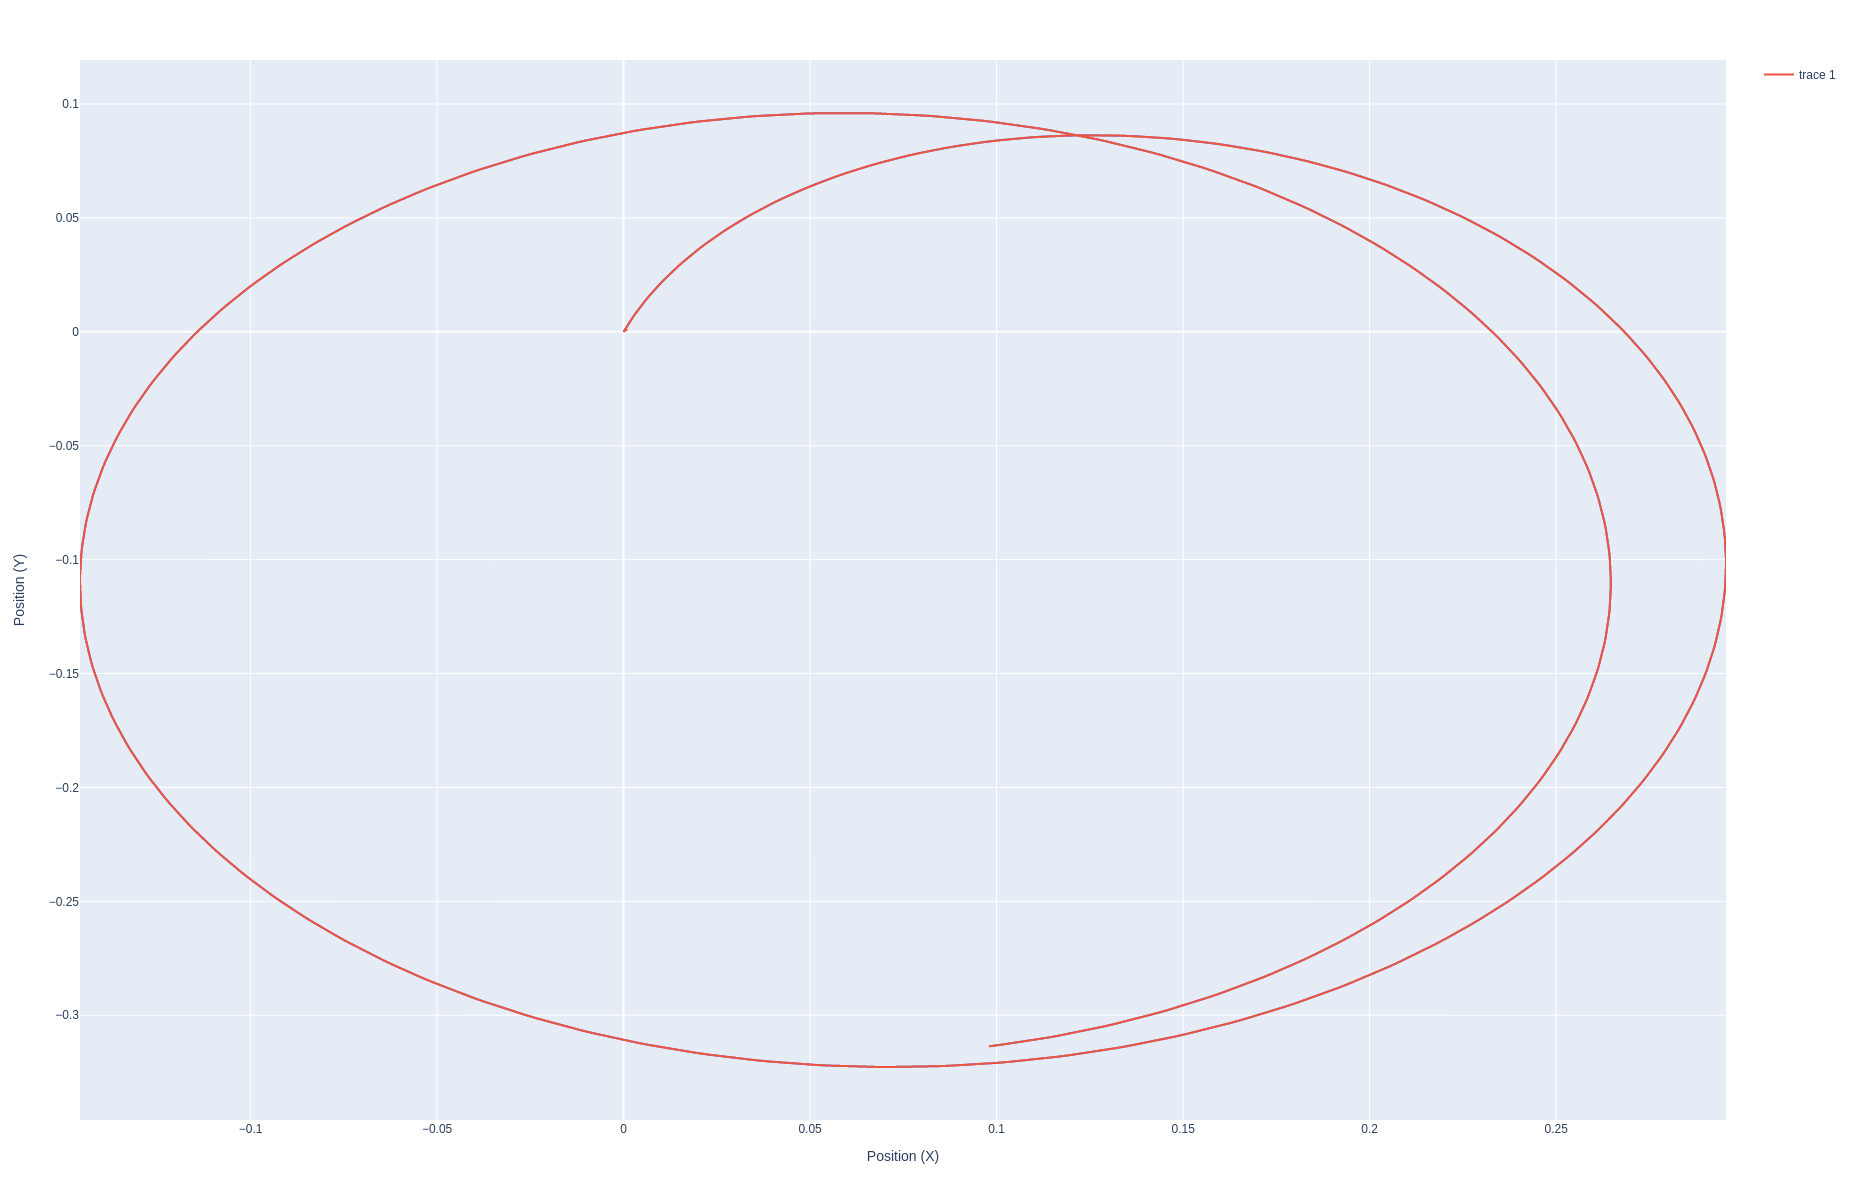

In [130]:
# AEKF
def run():
    # Simulation Initialization
    X_0 = np.array([0., 0., 0., 0., 0., 0.]).reshape((-1, 1))
    U = np.array([1, -1]).reshape((-1, 1))
    t_0 = 0
    t = t_0
    T = 12.0
    dt = 0.016
    state_time = []
    state_integrator = RK4_Integrator(X_0, t_0, T, dt, dx)
    
    # AEKF Init
    num_states = X_0.shape[0]
    x, t = state_integrator.step(U)
    x_hat = np.array([10., 10., 20., 0., 2., 1.]).reshape((-1, 1))
    theta = np.zeros((2, 1))
    theta_hat = np.zeros((2, 1)) # unclear
    P_plus = np.identity(num_states)
    Upsilon = 0 * B()
    S = 0.01 * np.identity(2)
    lamda = 0.997
    a = 1
    
    # AEKF Updatable params
    A = np.identity(6)
    QF = np.diag([0.0001 for _ in range(num_states)])
    RF = np.diag([0.0001 for _ in range(num_states)])
    C = np.identity(num_states)
    In = np.identity(num_states)
    Phi = -B() @ np.diag(U.reshape(-1))
    
    while t < T:
        # x += Phi @ theta
        F = (
            A + 
            dt * Jf(x_hat[0][0], x_hat[1][0], x_hat[2][0], x_hat[3][0], x_hat[4][0], x_hat[5][0])
        )
        

        # This following block should be repositioned and should be part of initialization like x_hat
        y = C @ x # not sure
        y_tilda = y - C @ x_hat

        P_minus = F @ P_plus @ F.T + QF
        Sigma = C @ P_minus @ C.T + RF
        K = P_minus @ C.T @ inv(Sigma)
        P_plus = (In - (K @ C)) @ inv(P_minus)

        QF = a * QF + (1-a) * (K @ y_tilda @ y_tilda.T @ K.T)
        RF = a * RF + (1-a) * ((y_tilda @ y_tilda.T) + (C @ P_minus @ C.T))

        Omega = (C @ F @ Upsilon) + (C @ Phi)       
        Upsilon = ((In - (K @ C)) @ F @ Upsilon) + (In - (K @ C)) @ Phi
        Lamda = inv((lamda * Sigma) + (Omega @ S @ Omega.T))
        Gamma = S @ (Omega.T @ Lamda)
        S = (S / lamda) - ((S @ Omega.T @ Lamda @ Omega @ S) / lamda)
        
        x_hat = (
            (A @ x_hat) + 
            fx(x) * dt +
            B() @ U +
            Phi @ theta_hat + 
            K @ y_tilda + 
            Upsilon @ Gamma @ y_tilda
        )
        theta_hat = theta_hat + Gamma @ y_tilda
        
        # Utility & state updates
        # result = state_integrator.step(u=np.zeros((2,1))) # force 0 update since we are updating it later
        
        # if result is None:
        #     break
        
        # mod = (
        #     # (A @ x) + 
        #     (B() @ U) + 
        #     Phi @ theta
        # ) # hax
        # x, t = result
        # x += mod # hax
        
        x = (
            x + 
            fx(x)*dt +
            (B() @ U)*dt +
            Phi @ theta
        )
        t += dt
        
        state_time.append({
            "Position (X)": x[0][0], 
            "Position (X`)": x_hat[0][0],
            "Position (Y)": x[1][0], 
            "Position (Y`)": x_hat[1][0],
            "Position (Sai)": x[2][0], 
            "Position (Sai`)": x_hat[2][0],
            "Vel (u)": x[3][0], 
            "Vel (u`)": x_hat[3][0],
            "Vel (v)": x[4][0], 
            "Vel (v`)": x_hat[4][0],
            "yaw rate (r)": x[5][0], 
            "yaw rate (r`)": x_hat[5][0],
            "Time": t
        })
            
    r_state_time_df = pd.DataFrame(state_time).set_index("Time")
    plot_state_vs_time(r_state_time_df)
    plot_path(r_state_time_df, x='Position (X`)', y='Position (Y`)')

run()